# Forecasting Run Expectancy Per Inning
**Goal:** Build a model that predicts expected runs scored *in an inning* for a batting team, using batter-level features (batter in batting rotation), contextual game features, and fielder defensive contribution (WAR). Run MC simulations of innings with simple logistic regression to sample for outcomes of at bats

**Notebook structure**
1. Config / params (easy-to-edit)
2. Data ingestion (pybaseball)
3. Feature engineering (batter-level + game context + batter-pitcher compatibility)
4. Create target: runs scored within an inning (team-inning)
5. Train/test splits
6. Markov state space model with logistic regression for transition probabilities
7. Evaluation: RMSE, MAE, coverage of CIs, calibration plots, example inning-level comparisons vs. observed
8. Notes on pitfalls, extensions, and alternatives


In [1]:
# Basic imports and configuration
import os
import numpy as np
import pandas as pd
from datetime import datetime
from joblib import Memory
import warnings

from pybaseball import statcast

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

#Pybaseball
from pybaseball import statcast, statcast_batter, playerid_lookup, batting_stats, batting_stats_range, statcast_pitcher
from pybaseball import pitching_stats, team_pitching, team_batting, schedule_and_record
    


# For saving / reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Make plotting look reasonable
plt.rcParams['figure.figsize'] = (10,5)


In [2]:
import warnings
warnings.filterwarnings("ignore")  # suppress all warnings

from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

import logging
logging.getLogger().setLevel(logging.ERROR)


In [3]:
# Configurable parameters
START = '2021-03-01'   # start of data pull window 
END   = '2024-11-01'   # end of data pull window
MIN_PLATE_APPEARANCES = 50    # threshold for batter-season aggregation
TEST_SIZE = 0.2
GP_N_SAMPLES = 2000           # Monte Carlo samples for predictive distribution





In [4]:
# Caching directory
CACHE_DIR = "./cache"
if not os.path.exists(CACHE_DIR):
    os.makedirs(CACHE_DIR)

memory = Memory(CACHE_DIR, verbose=1)

@memory.cache
def fetch_statcast(start_date, end_date):
    """Fetches Statcast with disk caching."""
    return statcast(start_date,end_date)

df_core = fetch_statcast(START, END)


In [5]:
#export columns to text file 
df_core.columns.to_series().to_csv("statcast_columns.txt", index=False)

In [6]:
#df_core number of rows and bytes
print(f"Statcast data from {START} to {END} has {df_core.shape[0]} rows and occupies {df_core.memory_usage(deep=True).sum() / (1024 ** 2):.2f} MB on disk.")

Statcast data from 2021-03-01 to 2024-11-01 has 3075349 rows and occupies 5534.19 MB on disk.


In [188]:
NEEDED = [
    "game_pk", "game_date",
    "batter", "pitcher", "stand",
    "inning", "outs_when_up",
    "on_1b", "on_2b", "on_3b", "age_pit", "age_bat", "balls", "strikes", "pitch_number", #(pitch_number is per PA)
    "pitch_name",    
    "if_fielding_alignment", "of_fielding_alignment",
    "bat_score", "fld_score", 
    "events", "description"]

df = df_core[NEEDED].copy()

df = df[::-1].reset_index(drop=True) #df_core is reverse chronological initially


In [189]:
#replace NaN in events with "PA_continues"
df["events"] = df["events"].fillna("PA_continues")

#df.sort_values(["pitcher", "game_date"])


df.head()


,game_pk,game_date,batter,pitcher,stand,inning,outs_when_up,on_1b,on_2b,on_3b,...,balls,strikes,pitch_number,pitch_name,if_fielding_alignment,of_fielding_alignment,bat_score,fld_score,events,description
0,641542,2021-03-15,650333,669060,L,1,0,<NA>,<NA>,<NA>,...,0,0,1,NaN,NaN,NaN,0,0,PA_continues,ball
1,641542,2021-03-15,650333,669060,L,1,0,<NA>,<NA>,<NA>,...,1,0,2,NaN,NaN,NaN,0,0,single,hit_into_play
2,641542,2021-03-15,595909,669060,L,1,0,650333,<NA>,<NA>,...,0,0,1,NaN,NaN,NaN,0,0,field_out,hit_into_play
3,641542,2021-03-15,680777,669060,R,1,1,650333,<NA>,<NA>,...,0,0,1,NaN,NaN,NaN,0,0,field_out,hit_into_play
4,641542,2021-03-15,666135,669060,L,1,2,650333,<NA>,<NA>,...,0,0,1,NaN,NaN,NaN,0,0,field_out,hit_into_play


In [190]:
#encode base states via bitmasking

df["base_state"] = (
    df["on_1b"].notna().astype(int)
    + 2 * df["on_2b"].notna().astype(int)
    + 4 * df["on_3b"].notna().astype(int)
)

df["base_state"].value_counts()

base_state
0    1753681
1     577403
2     243870
3     207744
5      86058
4      73711
7      70357
6      62525
Name: count, dtype: int64

In [79]:
df["events"].value_counts()

events
PA_continues                 2268763
field_out                     318709
strikeout                     183808
single                        113323
walk                           65811
double                         35312
home_run                       24848
force_out                      15973
grounded_into_double_play      14744
hit_by_pitch                    9253
sac_fly                         5276
field_error                     5253
triple                          3049
intent_walk                     2227
sac_bunt                        2144
fielders_choice                 1704
double_play                     1672
fielders_choice_out             1269
truncated_pa                    1264
strikeout_double_play            490
catcher_interf                   357
sac_fly_double_play               82
triple_play                       15
sac_bunt_double_play               3
Name: count, dtype: int64

In [80]:
(df.loc[df["events"] == "PA_continues"])['description'].value_counts()

description
ball                       954477
foul                       539112
called_strike              457404
swinging_strike            219186
blocked_ball                61937
foul_tip                    18188
automatic_ball               6915
swinging_strike_blocked      5011
foul_bunt                    4958
missed_bunt                   922
automatic_strike              379
pitchout                      177
bunt_foul_tip                  95
foul_pitchout                   1
hit_by_pitch                    1
Name: count, dtype: int64

In [191]:
# combines events/descriptions into broader categories for prediction

#future steps: take care of basestealing/pitchouts

def map_event(event, descr):
    if event in [
        "strikeout", "field_out", "force_out",
        "fielders_choice", "fielders_choice_out"]:
        return "OUT"

    if event in ["double_play", "triple_play", "sac_fly_double_play", "grounded_into_double_play", "strikeout_double_play"]:
        return "2OUT"

    if event in ["single", "field_error"]:
        return "SINGLE"

    if event in ["double"]:
        return "DOUBLE"
    
    if event in ["triple"]:
        return "TRIPLE"

    if event == "home_run":
        return "HR"

    if event in ["walk", "intent_walk", "hit_by_pitch", "catcher_interf"]:
        return "BB"

    if event in ["sac_bunt", "sac_fly"]:
        return "SAC"
    
    if event == "PA_continues":
        if descr in ["ball", "blocked_ball", "automatic_ball", "pitchout"]:
            return "BALL"
        if descr in ["foul", "foul_bunt", "foul_pitchout"]:
            return "FOUL"
        else:
            return "STRIKE"

    # Anything else treat as OUT
    return "OUT"

df["outcome"] = df.apply(lambda row: map_event(row['events'], row['description']), axis=1)

df["outcome"].value_counts()


outcome
BALL      1023506
STRIKE     701186
FOUL       544071
OUT        522730
SINGLE     118576
BB          77648
DOUBLE      35312
HR          24848
2OUT        17003
SAC          7420
TRIPLE       3049
Name: count, dtype: int64

In [192]:


#simplify pitch names
df["pitch_name"] = df["pitch_name"].replace(["Knuckleball", "Other", "Eephus", "Forkball", "Screwball", "Slow Curve", "Pitch Out"], "Exotic")
df['pitch_name'] = df['pitch_name'].fillna("Exotic")

pitch_types = df["pitch_name"].unique().tolist()

#pitcher stats calculation
#for each pitcher_id calculate pct of pitches for each pitch_name

#df = df.sort_values(['pitcher', 'game_date'])

#remove old pct columns if they exist
df = df.drop(columns=df.filter(regex='^pct_').columns, errors='ignore')


# total pitches thrown so far by pitcher
df['total_pitches'] = df.groupby('pitcher').cumcount()


# For each pitch type, get the running count of that pitch
for pitch in pitch_types:
    # Create a temporary binary column for this pitch type
    df['_temp_pitch'] = (df['pitch_name'] == pitch).astype(int)
    # Cumsum within each pitcher group
    df[f'count_{pitch}'] = df.groupby('pitcher')['_temp_pitch'].cumsum()
    # Clean up temp column
    df = df.drop(columns=['_temp_pitch'])

# Now compute percentages for each pitch type
for pitch in pitch_types:
    df[f'pct_{pitch}'] = df[f'count_{pitch}'] / (df['total_pitches'] + 1)

# Keep only the pct_ columns
pct_cols = [col for col in df.columns if col.startswith('pct_')]
pct_wide = df[pct_cols].copy()

#print(pct_wide.head())

# Fill NaN with 0
pct_wide = pct_wide.fillna(0)

# Verify the percentages sum to 1.0
print("Pct columns sum per row (should be 1.0):")
print(pct_wide.sum(axis=1).describe())




Pct columns sum per row (should be 1.0):
count    3.075349e+06
mean     1.000000e+00
std      5.304313e-17
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
dtype: float64


In [193]:
#batter stats calculation

df["on_base"] = df["outcome"].isin(["SINGLE", "DOUBLE", "TRIPLE", "HR", "BB"]).astype(int)
#filters out PA_continues events as well
df["pa_end"] = (~df["events"].isin(["PA_continues"])).astype(int) 

def add_rolling_stats(g):
    g["cum_pa"] = g["pa_end"].cumsum()
    g["cum_bases"] = g["on_base"].cumsum()
    g["OBP"] = g["cum_bases"] / g["cum_pa"]
    return g

df = df.groupby("batter", group_keys=False).apply(add_rolling_stats)

df["OBP"] = df["OBP"].fillna(0)


In [194]:

# EWMA hit rate per batter–pitch type
df['batter_vs_pitch_ewma'] = (
    df.groupby(['batter', 'pitch_name'])['on_base']
      .transform(lambda x: x.shift(1).ewm(alpha=0.1, adjust=False).mean())
      .fillna(0)
)

# pivot to wide
batter_vs_wide = (
    df.pivot_table(
        index=df.index,
        columns='pitch_name',
        values='batter_vs_pitch_ewma'
    )
    .add_prefix('batter_vs_')
    .fillna(0)
)

# remove old batter_vs_ columns if rerunning
df = df.drop(
    columns=df.filter(regex='^batter_vs_').columns,
    errors='ignore'
)

# join features
df = df.join(batter_vs_wide)


In [195]:

# replace 0 with df["OBP"] per row
batter_vs_cols=batter_vs_wide.columns.values
df[batter_vs_cols] = np.where(df[batter_vs_cols] == 0, df['OBP'].values[:, None], df[batter_vs_cols])



In [196]:
def compute_runs_scored(prev_base_state, outcome, balls, strikes):
    """
    Compute runs scored from a plate appearance and update base state and outs

    Args:
        prev_base_state (int/float): 3-bit base state before the PA (0-7). May be float/NaN.
        event (str or float): Statcast event type (after outcome grouping); may be NaN

    Returns:
        tuple: (new_base_state (int 0-7), runs_scored (int 0-4), new_resulting_outs (0,1,2), update_balls (0,1,2,3), update_strikes (0,1,2))
    """
    # Safely coerce base state to int (handle floats / NaN)
    #prev_base_state = int(np.nan_to_num(prev_base_state, 0))

    # Home run: batter + all runners score
    if outcome == "HR":
        return 0, 1 + prev_base_state.bit_count(), 0, 0, 0

    # Outs (not including sacrifice which moves runners)
    if outcome == "OUT" or (outcome == "STRIKE" and strikes == 2):
        return prev_base_state, 0, 1, 0, 0

    # Double-play / multi-out events
    if outcome == "2OUT":
        dp_dict = {
            0: 0,
            1: 0,
            2: 0,
            3: 1,
            4: 0,
            5: 1,
            6: 2,
            7: 3
        }
        return dp_dict[prev_base_state], 0, 2, 0, 0

    # Walks / BB
    walk_dict = {
        0: 1,
        1: 3,
        2: 3,
        3: 7,
        4: 5,
        5: 7,
        6: 7,
        7: 7
    }
    if outcome == "BB" or (outcome == "BALL" and balls == 3):  # batter takes their base
        if prev_base_state == 7:
            return 7, 1, 0, 0, 0 # bases loaded means one run scores
        else:
            return walk_dict.get(prev_base_state, prev_base_state), 0, 0, 0 ,0

    #PA_continues (can assume at this point that no walks/strikeouts result)
    if outcome == "BALL":
        return prev_base_state, 0, 0, balls+1, strikes
    if outcome == "STRIKE":
        return prev_base_state, 0, 0, balls, strikes+1
    if outcome == "FOUL":
        if strikes < 2:
            return prev_base_state, 0, 0, balls, strikes+1
        else: #can't strikeout on a foul ball
            return prev_base_state, 0, 0, balls, strikes



    # Sacrifice: advance runners one base (counts as an out)
    if outcome == "SAC":
        new_state = (2 * prev_base_state) % 8
        runs = (2 * prev_base_state) // 8
        return new_state, runs, 1, 0, 0

    # Hits: SINGLE, DOUBLE, TRIPLE
    advance_dict = {
        "SINGLE": 1,
        "DOUBLE": 2,
        "TRIPLE": 3
    }
    advance = advance_dict.get(outcome, 0)

    advanced_state = prev_base_state * (2 ** advance) + 2 ** (advance - 1) if advance > 0 else prev_base_state
    return advanced_state % 8, (advanced_state // 8).bit_count(), 0, 0, 0

In [197]:
#create features for batter order at each PA
# Batter order proxy
# Create plate appearance number within each game
df["pa_number"] = df.groupby("game_pk").cumcount()

# Batter index cycles through lineup (0-8)
df["batter_index"] = df["pa_number"] % 9


# # Shift within each game and inning group
# df["next_outs"] = df.groupby(["game_pk", "inning"])["outs_when_up"].shift(-1)
# df["next_bases"] = df.groupby(["game_pk", "inning"])["base_state"].shift(-1)
# df["next_batter"] = df.groupby(["game_pk"])["batter"].shift(-1)

# # Drop rows where there is no next PA in the same inning
# df = df.dropna(subset=["next_outs", "next_bases", "next_batter"])



In [201]:
# compute outs per pa and run scored per inning per pitcher

# Compute runs

arr= [compute_runs_scored(b, e, ball, k)[1] for b, e, ball, k in zip(df["base_state"], df["outcome"], df["balls"], df["strikes"])]

df["run_scored_per_pa"] = pd.Series(arr,
    index=df.index,
    dtype=int,
)

#sum up runs per inning per pitcher
df["run_scored"] = (
    df.groupby(["game_pk", "inning", "pitcher"])["run_scored_per_pa"]
      .transform("sum")
)

In [202]:

#encode lefty-righty stance of batter
if "stand_enc" not in df.columns:
    df["stand_enc"] = df["stand"].map({"R": 1, "L": 0}).fillna(0).astype(int)


In [203]:
#batter-pitcher matchup effictiveness
pct_cols = pct_wide.columns.values
batter_cols = batter_vs_wide.columns.values
pct_cols = [col for col in pct_cols if col != 'pct_nan']

# Extract the pitch type suffixes from both column sets
# batter_vs_ prefix has 10 characters, pct_ prefix has 4 characters
pct_pitch_types = {col.replace('pct_', ''): col for col in pct_cols}
batter_pitch_order = [col.replace('batter_vs_', '') for col in batter_cols]

# Reorder pct_cols to match batter_cols order
pct_cols_reordered = [pct_pitch_types[pitch] for pitch in batter_pitch_order if pitch in pct_pitch_types]

df['expected_hit'] = (
    df[pct_cols_reordered].to_numpy() *
    df[batter_cols].to_numpy()
).sum(axis=1)

df["expected_hit"].describe()


count    3.075349e+06
mean     2.548482e-01
std      6.957461e-02
min      0.000000e+00
25%      2.153358e-01
50%      2.567348e-01
75%      2.945338e-01
max      1.000000e+00
Name: expected_hit, dtype: float64

In [204]:
#perform label encoding on features relevant to predicting PA events

from sklearn.preprocessing import LabelEncoder


FEATURES = [
    "OBP",
    "stand_enc",
    "outs_when_up",
    "base_state",
    "balls",
    "strikes",
    "pitch_number",
    "bat_score","fld_score",
    "inning",
    "expected_hit",
    "outcome"
]

#FEATURES.extend(pct_wide.columns.values)
#FEATURES.extend(batter_vs_wide.columns.values)

X = df[FEATURES].dropna()
le = LabelEncoder()
y = le.fit_transform(X["outcome"])     # fit on ALL states
X=X.drop(columns=["outcome"])

num_classes = len(le.classes_)

FEATURES.remove("outcome")


In [205]:
#0.8 to 0.1 to 0.1 split for train-test-validation

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled  = scaler.transform(X_test)
#X_val_scaled  = scaler.transform(X_val)


In [206]:
#train xgboost

from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# --- impute missing values (fit on original training split) ---
imputer = SimpleImputer(strategy="mean")
X_train = imputer.fit_transform(X_train)
X_val = imputer.transform(X_val)
X_test = imputer.transform(X_test)

# --- oversample minority classes in the training set ---
ros = RandomOverSampler(random_state=RANDOM_SEED)
X_train_res, y_train_res= X_train, y_train
#X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

# print("Class distribution before:", Counter(y_train))
# print("Class distribution after: ", Counter(y_train_res))


# --- train XGBoost with early stopping on validation set ---
clf = XGBClassifier(
    objective="multi:softprob",
    eval_metric="mlogloss",
    use_label_encoder=False,
    random_state=RANDOM_SEED,
    n_jobs=-1
)

clf.fit(
    X_train_res,
    y_train_res,
    eval_set=[(X_val, y_val)],
    verbose=False
)

# Keep original class names for downstream mapping
clf.all_classes_ = le.classes_


In [207]:
#event prediction model validation

from sklearn.metrics import log_loss, accuracy_score, classification_report


def expand_proba(proba_small, trained_classes):
    """
    Handles both:
        (N_classes,)       -> single row
        (N_samples,N_classes) -> batch
    """
    proba_small = np.asarray(proba_small)

    # CASE 1: single sample vector
    if proba_small.ndim == 1:
        full = np.zeros(num_classes)
        full[trained_classes] = proba_small
        return full

    # CASE 2: batch (N_samples x N_classes)
    N = proba_small.shape[0]
    full = np.zeros((N, num_classes))
    full[:, trained_classes] = proba_small
    return full




# Predict probabilities and labels
val_pred_proba = clf.predict_proba(X_val)


val_pred_proba_full = expand_proba(
    val_pred_proba,
    clf.classes_
)



val_logloss = log_loss(
    y_val,
    val_pred_proba_full,
    labels=np.arange(num_classes)
)

val_pred       = clf.predict(X_val)

val_acc     = accuracy_score(y_val, val_pred)

print("====== Validation Results ======")
print(f"Log-loss:   {val_logloss:.4f}")
print(f"Accuracy:   {val_acc:.4f}")



print("\nClassification report:\n")
y_val_str  = le.inverse_transform(y_val)
y_pred_str = le.inverse_transform(val_pred)

# Full list of original class names
target_names = list(le.classes_)

# Print report
print(classification_report(
    y_val_str,
    y_pred_str,
    labels=target_names,
    target_names=target_names
))

====== Validation Results ======
Log-loss:   1.4392
Accuracy:   0.3813

Classification report:

              precision    recall  f1-score   support

        2OUT       0.00      0.00      0.00      1700
        BALL       0.38      0.67      0.49    102351
          BB       0.39      0.21      0.27      7765
      DOUBLE       0.00      0.00      0.00      3531
        FOUL       0.29      0.01      0.02     54407
          HR       0.00      0.00      0.00      2485
         OUT       0.38      0.30      0.33     52273
         SAC       0.00      0.00      0.00       742
      SINGLE       0.28      0.00      0.00     11857
      STRIKE       0.39      0.44      0.41     70119
      TRIPLE       0.00      0.00      0.00       305

    accuracy                           0.38    307535
   macro avg       0.19      0.15      0.14    307535
weighted avg       0.35      0.38      0.32    307535



In [208]:
# "OBP",
#     "stand_enc",
#     "outs_when_up",
#     "base_state",
#     "balls",
#     "strikes",
#     "pitch_number",
#     "bat_score","fld_score",
#     "inning",
#     "expected_hit",
#     "outcome"

X_dummy = [[0.2, 0, 0, 0, 0, 1, 12, 1, 1, 4, 0.2]]

val_pred_proba = clf.predict_proba(X_dummy)


val_pred_proba_full = expand_proba(
    val_pred_proba,
    clf.classes_
)
print(val_pred_proba_full)

print(le.inverse_transform(clf.predict(X_dummy)))

[[6.45865214e-07 2.40679532e-01 1.56940927e-03 1.03093097e-02
  2.42712572e-01 9.33883805e-03 1.71600655e-01 3.98732993e-07
  4.27419208e-02 2.72026449e-01 9.02029593e-03]]
['STRIKE']


In [209]:
#compute percent of time out is recorded amongst pitches (not all PA) going through all of df[FEATURES]

total_outs=0
total_pa=0

for _ in range(1000):
    i = np.random.randint(0, len(df))
    X= df.iloc[i][FEATURES].values
    X = imputer.transform(X.reshape(1, -1))
    probs_pred = clf.predict_proba(X)[0]
    observed_classes = clf.classes_
    outcome_event =  le.inverse_transform([np.random.choice(observed_classes, p=probs_pred)])[0]
      
    if outcome_event in ["OUT", "2OUT"]:
        total_outs+=1
    total_pa+=1
print(total_outs/1000)


0.179


In [210]:
#for features in FEATURES (sans outcome) compute mean values
for feature in FEATURES:
    if feature != "outcome":
        df[f"avg_{feature}"]= df.groupby("batter")[feature].transform("mean")

In [218]:
def extract_batter_rotation(i, df, num_batters=9):
    """
    Extract OBP for the next 9 batters in rotation.
    
    Parameters
    ----------
    i : int
        Starting row index in df.
    df : pandas.DataFrame
        Must contain batter info and avg_OBP column.
    num_batters : int
        Number of batters to extract (default 9 for full lineup).
    
    Returns
    -------
    obp_rotation : list of float
        OBP values for each batter in the rotation.
    """
    stats_rotation = []
    row = df.iloc[i]
    current_batter = row["batter"]
    
    for _ in range(num_batters):
        try:
            batter_row = df[df["batter"] == current_batter].iloc[0]
            obp = batter_row.get("avg_OBP", df["OBP"].mean())
            eh = batter_row.get("expected_hit", 0.25)
        except:
            obp = df["OBP"].mean()
            eh = 0.25
        
        stats_rotation.append((obp, eh))
        
        # Advance to next batter in rotation
        try:
            next_row = df[df["batter"] == current_batter].iloc[0]
            next_batter_candidate = next_row.get("next_batter", None)
            
            if pd.notna(next_batter_candidate):
                current_batter = next_batter_candidate
        except:
            break
    
    return stats_rotation


def simulate_inning(stats_rotation, base_features, clf, accum_outcomes):
    """
    Simulate a single inning cycling through batter rotation
    
    args

    stats_rotation : list of batter stat tuple values for each batter in rotation.
    base_features : dict
        Dictionary containing base feature values:
        - "stand_enc", "balls", "strikes", "pitch_number", 
        - "bat_score", "fld_score", "inning"
    clf : trained XGBClassifier
        Predicts PA outcome probabilities.
    accum_vals : dict of total number of homers, triples, doubles, singles, bb
        
    Returns

    runs : int
        Total runs scored in this simulated inning.
    """
    outs = 0
    base_state = 0
    runs = 0
    max_pitches = 100 #longest inning lasted 61 pitches
    batter_idx = 0
    balls = base_features["balls"]
    strikes = base_features["strikes"]
    new_batter = False #True if we are moving onto the next batter
    
    for _ in range(max_pitches):
        if outs >= 3:
            break
        
        if new_batter:
            batter_idx += 1
            new_batter = False
        # Get stats for current batter in rotation
        obp, eh = stats_rotation[batter_idx % len(stats_rotation)]
            
            
        # Build feature vector: [OBP, stand_enc, outs, base_state, balls, strikes, pitch_number, bat_score, fld_score, inning]
        X_row = np.array([
            obp,
            base_features["stand_enc"],
            outs,
            base_state,
            balls,
            strikes,
            base_features["pitch_number"],
            base_features["bat_score"],
            base_features["fld_score"],
            base_features["inning"],
            eh
        ]).reshape(1, -1)
        
        # Impute and predict
        X_imputed = imputer.transform(X_row)
        probs_pred = clf.predict_proba(X_imputed)[0]
        observed_classes = clf.classes_
        
        # Sample outcome
        outcome = le.inverse_transform(
            [np.random.choice(observed_classes, p=probs_pred)]
        )[0]
        
        # Update state
        base_state, RBI, new_outs, balls, strikes = compute_runs_scored(base_state, outcome, balls, strikes)
        outs += new_outs
        if outs < 3:
            runs += RBI

        if outcome not in ["BALL", "STRIKE", "FOUL"]:
            new_batter = True
        accum_outcomes[outcome] += 1
        accum_outcomes["TOTAL"] += 1
        #print(base_state, RBI, outcome, balls, strikes)
    
    return runs

In [213]:

#sub data frame containing only rows for start of an inning


df_inning_start = df[(df["outs_when_up"] == 0) & (df["base_state"] == 0) & (df["balls"] == 0) & (df["strikes"] == 0)].sort_index()



In [219]:
from collections import defaultdict

num_rows = df_inning_start.shape[0]
NUM_SIM = 100

simulated = []
#dict for tracking total number of each outcome
accum_outcomes = defaultdict(int)

for _ in range(NUM_SIM):
    idx = np.random.randint(0, num_rows)

    row = df_inning_start.iloc[idx]
    
    # Extract base_features from the random row
    base_features = {
        "stand_enc": row.get("stand_enc", 0),
        "balls": row.get("balls", 0),
        "strikes": row.get("strikes", 0),
        "pitch_number": row.get("pitch_number", 0),
        "bat_score": row.get("bat_score", 0),
        "fld_score": row.get("fld_score", 0),
        "inning": row.get("inning", 5),
    }

    #extract index from original df
    og_idx = df_inning_start.index[idx]
    # Extract batter rotation and simulate

    stats_rot = extract_batter_rotation(og_idx, df)
    runs = simulate_inning(stats_rot, base_features, clf, accum_outcomes)
    simulated.append(runs)

#note inspection paradox occurs with higher sampling from plate appearences in long innings (more runs)
print(f"Mean simulated runs starting from start of random inning: {np.mean(simulated):.3f}")
print(f"SE simulated runs/inning: {np.sqrt(np.var(simulated)):.3f}")
print(accum_outcomes)


Mean simulated runs starting from start of random inning: 0.700
SE simulated runs/inning: 1.533
defaultdict(<class 'int'>, {'FOUL': 186, 'TOTAL': 1430, 'STRIKE': 348, 'OUT': 273, 'BALL': 415, 'BB': 53, 'DOUBLE': 29, 'SAC': 5, 'SINGLE': 95, '2OUT': 11, 'HR': 15})


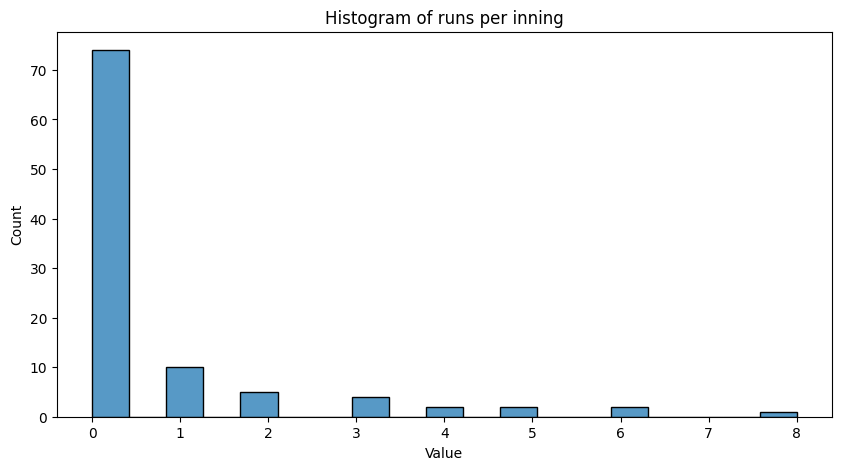

<Axes: xlabel='run_scored', ylabel='Count'>

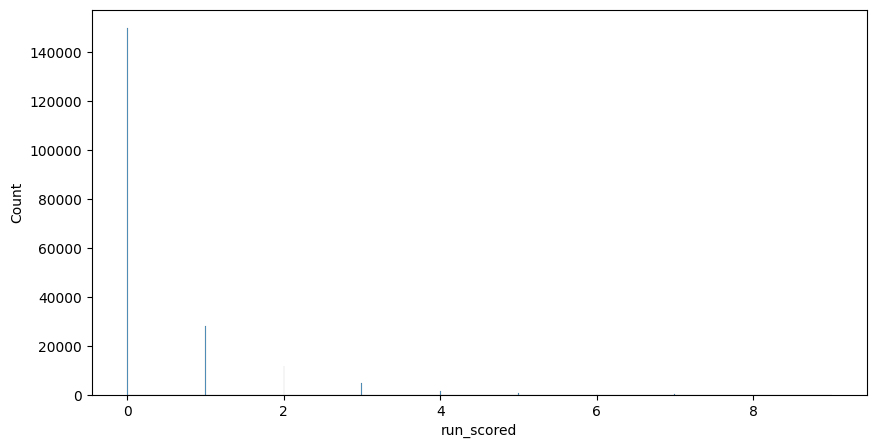

In [220]:
#plot distribution of runs scored per inning in simulation vs actual data

import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data=simulated)
plt.title("Histogram of runs per inning")
plt.xlabel("Value")
plt.ylabel("Count")
plt.show()

sns.histplot(data=df_inning_start["run_scored"])



In [222]:
from scipy.spatial.distance import jensenshannon
from scipy.special import rel_entr

support = list(range(13))

p = pd.Series(simulated).value_counts(normalize=True).reindex(support, fill_value=0).to_numpy()
q = df_inning_start["run_scored"].value_counts(normalize=True).reindex(support, fill_value=0).to_numpy()

#jensen shannon divergence
js_div = jensenshannon(p, q) ** 2
print(f"Jensen Shannon Divergence: {js_div}")

#kullback leibler divergence
eps = 1e-12
kl_pq = np.sum(rel_entr(p + eps, q + eps))
print(f"Kullback-Leibler divergence: {kl_pq}")

Jensen Shannon Divergence: 0.017578632675705388
Kullback-Leibler divergence: 0.14142556114247615
